In [1]:
from ddks.data import *
from ddks.data.openimages_dataset import LS
from ddks import methods
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import tqdm
import os
import pickle
plt.style.use('ah')
plt.show()

In [2]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [3]:
methods_list = [methods.ddks_method,  methods.onedks_method, methods.hotelling_method, methods.kldiv_method]
datasets = [GVM, GVS, Skew, DVU, MM]
sample_size = 50

def within(x, y, eps=1.0E-3):
    return np.abs(x - y) < eps

def return_mean_significance(_method, Dataset, dimension, parameter, permutations=100):
    if Dataset.name == 'GVM':
        kwargs = dict(mean_p=0.5+parameter, mean_t=0.5)
    elif Dataset.name == 'GVS':
        kwargs = dict(std_p=0.5+parameter, std_t=0.5)
    elif Dataset.name == 'Skew':
        kwargs = dict(lambda_p=0.5+parameter, lambda_t=0.5)
    elif Dataset.name == 'DVU':
        kwargs = dict(width_p=1.0 - parameter)
    elif Dataset.name == 'MM':
        kwargs = dict(mean_p=1.0, mean_t=0.0, std=1.0, noise_fraction=1.0 - parameter)
        
    _dataset = Dataset(dimension=dimension, sample_size=sample_size, **kwargs)
    p, t = next(_dataset)
    return _method(p, t, permutations)

def bisection(_method, Dataset, dimension, permutations=100, trials=10):
    mids = []
    for i in tqdm.tqdm(np.arange(trials)):
        low = 0.0
        high = 5.0
        if (Dataset.name == 'MM') or (Dataset.name == 'DVU'):
            high = 1.0
        mid = (low + high) / 2
        low_sig = return_mean_significance(_method, Dataset, dimension, low, permutations)
        high_sig = return_mean_significance(_method, Dataset, dimension, high, permutations)
        mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
        significance = 1.0
        while not within(mid_sig, 0.05):
            if low_sig > 0.05 and mid_sig < 0.05:
                new_mid = (low + mid) / 2
                high = mid
                high_sig = mid_sig
                mid = new_mid
                mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
            elif mid_sig > 0.05 and high_sig < 0.05:
                new_mid = (mid + high) / 2
                low = mid
                low_sig = mid_sig
                mid = new_mid
                mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
            else:
                #print(f"Low: {low:.2f}, {low_sig:.2f} | Mid: {mid:.2f}, {mid_sig:.2f} | High: {high:.2f}, {high_sig:.2f}")
                mid = np.nan
                break
        mids.append(mid)
    
    mean = np.nanmean(mids)
    std = np.nanstd(mids)
    if Dataset.name == 'MM':
        mean = np.nanmean(1.0 - np.array(mids))
        std = np.nanstd(1.0 - np.array(mids))
    return mean, std, np.sum(np.isfinite(mids))
        

In [4]:
data = {}
if os.path.exists('ddks_shrinkage.pkl'):
    data = pickle.load(open('ddks_shrinkage.pkl', 'rb'))
else:
    for dataset in datasets:
        data[str(dataset)] = dict()
        for metric in methods_list:
            data[str(dataset)][metric.name] = bisection(metric, dataset, dimension=3)
            print(str(dataset), metric.name, data[str(dataset)][metric.name])
    pickle.dump(data, open('ddks_shrinkage.pkl', 'wb'))

In [5]:
print(data)

{"<class 'ddks.data.GVM'>": {'ddKS': (0.3269971327427842, 0.04627292359865665, 8), 'OneDKS': (0.42997360902074166, 0.13167278337434515, 10), 'Hotelling-T2': (0.2952454418737493, 0.07333069789428823, 10), 'KLDiv': (1.1335683965602454, 0.21928719519455178, 10)}, "<class 'ddks.data.GVS'>": {'ddKS': (0.2568784856121056, 0.060713153652608785, 10), 'OneDKS': (0.5037211323997001, 0.15971240011399096, 10), 'Hotelling-T2': (4.995021817449014, 0.004940030921717131, 2), 'KLDiv': (1.0433505976187403, 0.7626795319351142, 9)}, "<class 'ddks.data.Skew'>": {'ddKS': (0.2655583251825527, 0.06465951608734706, 9), 'OneDKS': (0.2598577635321073, 0.09659265640213384, 9), 'Hotelling-T2': (0.17510625410876754, 0.04026411991851034, 9), 'KLDiv': (0.3133320492963251, 0.0740312184555328, 8)}, "<class 'ddks.data.DVU'>": {'ddKS': (0.28019164668189156, 0.10958931144174636, 9), 'OneDKS': (0.483612060546875, 0.016387939453125, 2), 'Hotelling-T2': (0.49951171875, 0.0, 1), 'KLDiv': (0.6390547823398095, 0.114448617470188

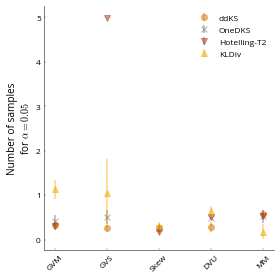

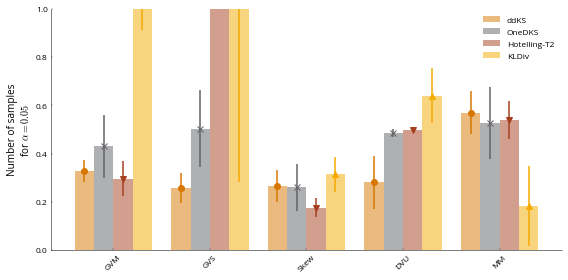

In [9]:
fig = plt.figure(figsize=(4, 4))
markers = ['o', 'x', 'v', '^']
#gvm
for metric, marker in zip(data[list(data.keys())[0]].keys(), markers):
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    plt.errorbar(np.arange(len(means)), means, yerr=stds, linestyle='none', marker=marker, label=metric, alpha=0.5)
plt.xticks(np.arange(len(datasets)), ['GVM', 'GVS', 'Skew', 'DVU', 'MM', 'LS'], rotation=45)
plt.ylabel('Number of samples' + "\n" + r'for $\alpha=0.05$')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 4))
markers = ['o', 'x', 'v', '^']
#gvm
for i, (metric, marker) in enumerate(zip(data[list(data.keys())[0]].keys(), markers)):
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    plt.bar(np.arange(len(means)) + (i/5.0 - 0.5), means, label=metric, width=0.20, alpha=0.5)
    plt.errorbar(np.arange(len(means)) + (i/5.0 - 0.5), means, yerr=stds, linestyle='none', marker=marker)
plt.xticks(np.arange(len(datasets)) - 0.20, ['GVM', 'GVS', 'Skew', 'DVU', 'MM', 'LS'], rotation=45)
plt.ylabel('Number of samples' + "\n" + r'for $\alpha=0.05$')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

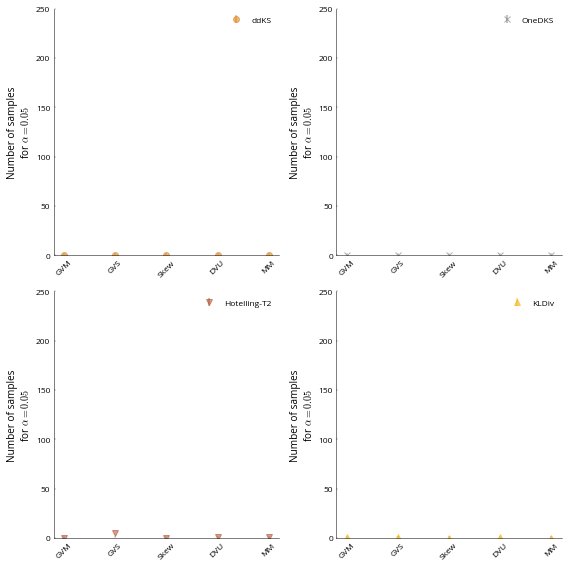

In [12]:
fig = plt.figure(figsize=(8, 8))
markers = ['o', 'x', 'v', '^']
#gvm
colors = ['#D77600', '#616265', '#A63F1E', '#F4AA00', '#007836', '#00338E', '#870150']
for i, (metric, marker, color) in enumerate(zip(data[list(data.keys())[0]].keys(), markers, colors)):
    plt.subplot(221+i)
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    plt.errorbar(np.arange(len(means)), means, yerr=stds, linestyle='none', color=color, marker=marker, label=metric, alpha=0.5)
    plt.xticks(np.arange(len(datasets)), ['GVM', 'GVS', 'Skew', 'DVU', 'MM', 'LS'], rotation=45)
    plt.ylabel('Number of samples' + "\n" + r'for $\alpha=0.05$')
    plt.ylim(0, 250)
    plt.legend()
plt.show()

ddKS
OneDKS
Hotelling-T2
KLDiv


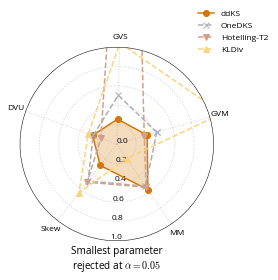

In [34]:
#markers = ['/', '\\', '|', '.']
theta = radar_factory(5, frame='circle')
fig, axs = plt.subplots(figsize=(4, 4), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
rgrids = np.linspace(0.0, 1.0, 6)
plt.gca().set_rgrids(rgrids, labels=[f'{r:.1f}' for r in rgrids])
colors = ['#D77600', '#B0B0B2', '#D29F8E', '#F9D47F']
for metric, marker, color in zip(data[list(data.keys())[0]].keys(), markers, colors):
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    if 'ddKS' in metric:
        linestyle = '-'
    else:
        linestyle = '--'
    line = plt.plot(theta, means, label=metric, color=color, linestyle=linestyle, marker=marker)
    print(metric)
    if 'ddKS' in metric:
        plt.fill(theta, means, alpha=0.25, facecolor=color)
plt.gca().set_xlabel('Smallest parameter' + "\n" + r'rejected at $\alpha=0.05$')
plt.gca().set_rlabel_position(-90.0 - 20.0)
plt.gca().set_theta_offset(-6.0)
plt.gca().set_rlim(0.0, 1.0)
plt.grid(color='#AAAAAA', linewidth=1.0)
plt.gca().set_varlabels(['GVM', 'GVS', 'DVU', 'Skew', 'MM', 'LS'])
plt.legend(loc=(0.9, .95))
plt.savefig('shrinkage_radar.pdf')
plt.show()